In [1]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import time

# import data

In [2]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

,Title,Userscore,Comment,lang
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it...",en
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...,en
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...,en
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...,en
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...,en


In [3]:
df.shape

(155554, 4)

# plots

- userscore distribution

In [4]:
df.Userscore.value_counts(normalize=True).sort_index()

1.0     0.026145
2.0     0.021787
3.0     0.025438
4.0     0.028614
5.0     0.037138
6.0     0.044493
7.0     0.063502
8.0     0.111325
9.0     0.200818
10.0    0.440741
Name: Userscore, dtype: float64

c:\Users\qwswe\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


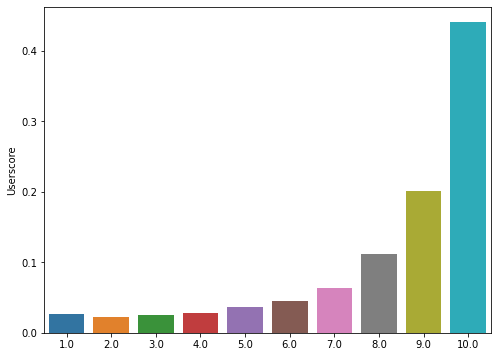

In [6]:
snsdf = df.Userscore.value_counts(normalize=True).sort_index()
snsdf = pd.DataFrame(snsdf)
snsdf

plt.figure(figsize=(8,6))
sns.barplot(snsdf.index, snsdf.Userscore);

# 44% user gave a 10.0

- length of comments

In [7]:
df['Comment_len'] = df['Comment'].map(lambda x: len(x))

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

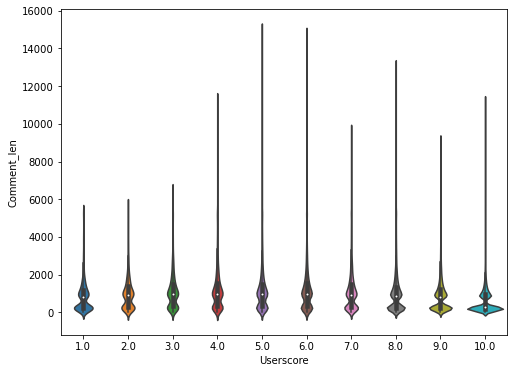

In [8]:
plt.figure(figsize=(8,6))
sns.violinplot(y=df['Comment_len'], x=df['Userscore'])

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

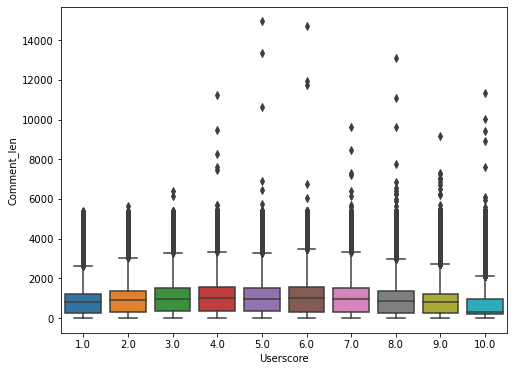

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(y=df['Comment_len'], x=df['Userscore'])

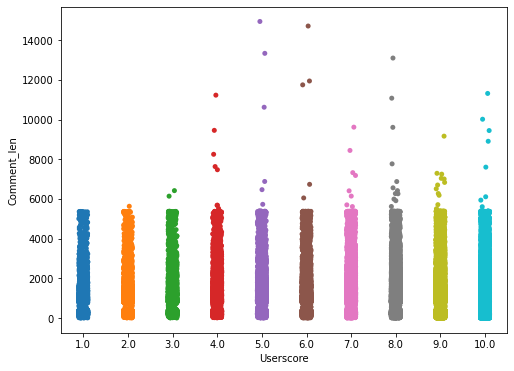

In [10]:
plt.figure(figsize=(8,6))
sns.stripplot(y=df['Comment_len'], x=df['Userscore']);

- popular game title

In [11]:
df['Title'].value_counts()

Call of Duty: Modern Warfare 3                     3663
The Elder Scrolls V: Skyrim                        3518
Mass Effect 3                                      2982
The Witcher 3: Wild Hunt                           2615
Grand Theft Auto V                                 2583
                                                   ... 
Rollcage Stage II                                     1
GT Advance Championship Racing                        1
Life is Strange: Episode 5 - Polarized                1
Combat Flight Simulator 2: WWII Pacific Theater       1
Skullgirls: 2nd Encore                                1
Name: Title, Length: 1497, dtype: int64

<AxesSubplot:>

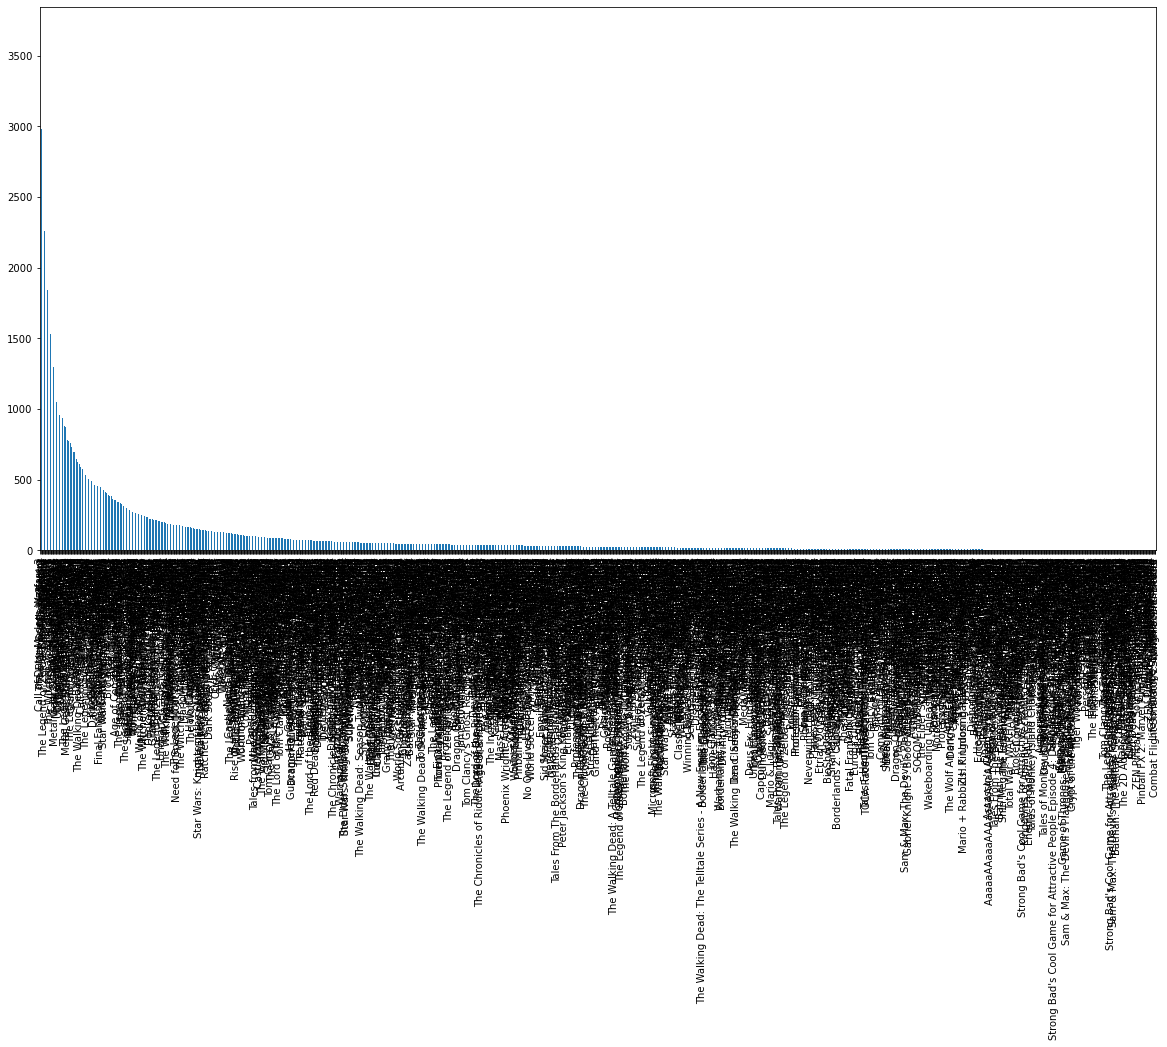

In [12]:
plt.figure(figsize=(20,10))
df['Title'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

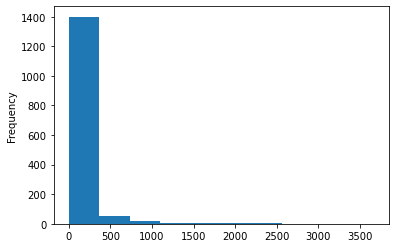

In [13]:
df.groupby('Title').size().plot(kind='hist', bins=10)

# preprocessing

* Capitalization
* Special pattern
* Numbers

In [14]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # drop non-english words
    words = set(nltk.corpus.words.words())
    # " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words))]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # cutoff for tokenized length
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [15]:
df.shape

(155554, 5)

In [16]:
df['Userscore'].value_counts(normalize=True)

10.0    0.440741
9.0     0.200818
8.0     0.111325
7.0     0.063502
6.0     0.044493
5.0     0.037138
4.0     0.028614
1.0     0.026145
3.0     0.025438
2.0     0.021787
Name: Userscore, dtype: float64

In [17]:
df_sub = df.sample(1555,random_state=2333) # 1% of origin
df_sub['Userscore'].value_counts(normalize=True)

10.0    0.430868
9.0     0.208360
8.0     0.104823
7.0     0.058521
6.0     0.051447
5.0     0.043087
4.0     0.031511
1.0     0.025723
3.0     0.023794
2.0     0.021865
Name: Userscore, dtype: float64

In [18]:
start = time.time()
df_sub['Comment'] = df_sub['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

162.19570779800415 seconds slipped.


In [19]:
df_sub_10 = df.sample(15555,random_state=2333) # 10% of origin
df_sub_10['Userscore'].value_counts(normalize=True)

10.0    0.442044
9.0     0.198779
8.0     0.109225
7.0     0.066410
6.0     0.042752
5.0     0.039280
1.0     0.027515
4.0     0.026230
3.0     0.025265
2.0     0.022501
Name: Userscore, dtype: float64

In [20]:
start = time.time()
df_sub_10['Comment'] = df_sub_10['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

In [96]:
start = time.time()
df['Comment'] = df['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

KeyboardInterrupt: 

**pickle**

In [85]:
df.to_pickle('processed_df/preprocessed_nlp.pkl')
# proprocessed texts, 155554, non-english, no userscore 0.0

# df = pickle.load(open('processed_df/preprocessed_nlp','rb'))

# count vectorization

In [127]:
ctvectorizer = CountVectorizer(min_df = 0.05, max_df = 0.8)
ctdf = ctvectorizer.fit_transform(corpus)

In [141]:
bow_mat = pd.DataFrame(ctdf.toarray(), columns = ctvectorizer.get_feature_names_out())
bow_mat['Userscore'] = df['Userscore']

In [152]:
high_bow_mat = bow_mat[bow_mat['Userscore'] == 10.0].drop(columns = ['Userscore'])

N_tok = high_bow_mat.sum(axis=0)
N = high_bow_mat.values.sum()

proba_c = N_tok/N

proba_c.sort_values(ascending=False)[0:20]

play         0.036519
get          0.024739
make         0.022059
good         0.021549
story        0.020625
great        0.019716
time         0.019339
really       0.016447
well         0.016330
best         0.016087
fun          0.013801
character    0.013444
even         0.013130
much         0.013075
go           0.012869
graphic      0.012830
first        0.012382
new          0.012234
feel         0.012080
give         0.011523
dtype: float64

In [154]:
low_bow_mat = bow_mat[bow_mat['Userscore'] <2.0].drop(columns = ['Userscore'])

N_tok = low_bow_mat.sum(axis=0)
N = low_bow_mat.values.sum()

proba_c = N_tok/N

proba_c.sort_values(ascending=False)[0:20]

play         0.036675
get          0.024818
good         0.022637
make         0.021986
story        0.019466
great        0.018712
time         0.018556
well         0.016858
really       0.015816
best         0.013842
fun          0.013727
go           0.013526
much         0.013416
character    0.012962
graphic      0.012858
new          0.012841
feel         0.012542
even         0.012507
give         0.011454
gameplay     0.011229
dtype: float64

# TFIDF

In [72]:
# after proprocess, there will be empty comment
# due to min_length

df_new = df[df['Comment'] != '']

In [107]:
corpus = df_new['Comment']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<244911x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 10248770 stored elements in Compressed Sparse Row format>

In [108]:
X_train.shape

(244911, 3000)

In [109]:
len(vectorizer.get_feature_names_out())

3000

In [112]:
feature_names = vectorizer.get_feature_names() #get tfidf vector for first document 
first_document_vector = X_train[0]  #print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False).head(15)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
oot,0.474807
perfection,0.384035
rat,0.366689
critic,0.350652
wonder,0.331167
highly,0.291505
huge,0.251081
everything,0.216101
player,0.190024
really,0.154725


# Topic Modeling

In [79]:
topic_model = NMF(n_components = 7)
topic_model.fit(X_train)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=7)

In [80]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (7, 224661)
Shape of H is (244911, 7)
Shape of X_train is (244911, 224661)


In [81]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amazing', 'day', 'enjoy', 'still', 'come', 'know', 'even', 'go', 'want', 'review', 'never', 'think', 'first', 'say', 'hour', 'year', 'give', 'people', 'buy', 'fun', 'time', 'love', 'get', 'play', 'game']


THE TOP 10 WORDS FOR TOPIC #1
['uncharted', 'character', 'beautiful', 'probably', 'simply', 'video', 'amazing', 'awesome', 'world', 'mario', 'masterpiece', 'series', 'perfect', 'far', 'year', 'gameplay', 'rpg', 'story', 'amaze', 'graphic', 'make', 'play', 'game', 'ever', 'best']


THE TOP 10 WORDS FOR TOPIC #2
['action', 'combat', 'visuals', 'atmosphere', 'puzzle', 'well', 'voice', 'perfect', 'soundtrack', 'beautiful', 'excellent', 'sound', 'love', 'fantastic', 'amazing', 'music', 'fun', 'awesome', 'amaze', 'character', 'gameplay', 'game', 'graphic', 'story', 'great']


THE TOP 10 WORDS FOR TOPIC #3
['team', 'well', 'weapon', 'zombie', 'modern', 'black', 'play', 'warfare', 'shooter', 'fps', 'ops', 'battlefield', 'online', 'call', 'map', 'duty', 'new', 'fun', 'cod', 'single', 'mode'

In [82]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 7, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

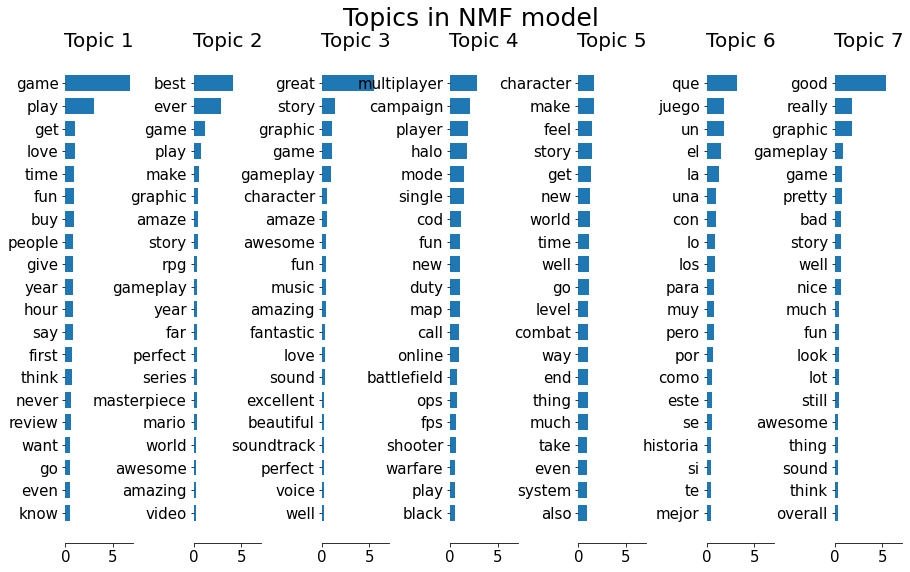

In [83]:
topic_word_plot()

In [156]:
topic_name_dict = {0: 'general good game', 1: 'mario world', 2: 'great story and audio',
                   3: 'multiplayer shooter', 4: 'combat world', 5:'espanola juego', 6:'overall good game with everything'}

# TSNE

In [155]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [157]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

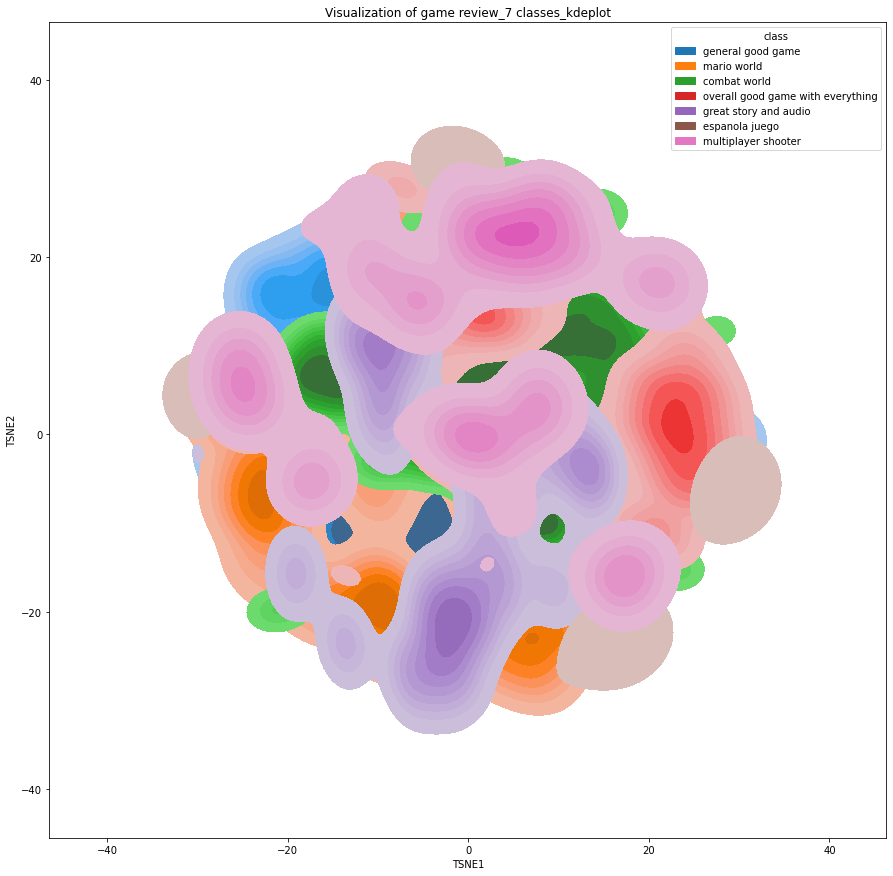

In [165]:
plt.figure(figsize=(15,15))
sns.kdeplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10', fill=True)
plt.title('Visualization of game review_7 classes_kdeplot')
plt.show()